Excerpts of notebook taken from http://www.xavierdupre.fr/app/cpyquickhelper/helpsphinx/notebooks/cbenchmark_branching2html.html

In [42]:
# !pip install jyquickhelper
# !pip install mkl
# !pip install cpyquickhelper

In [3]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [4]:
%matplotlib inline

In [10]:
try:
    import mkl
    mkl.set_num_threads(1)
except ModuleNotFoundError as e:
    print('mkl not found', e)
    import os
    os.environ['MKL_NUM_THREADS']='1'

mkl not found No module named 'mkl'


## Experiment: dot product, numpy vs C++

### Simple Numpy

In [20]:
import numpy
from timeit import Timer

def simple_dot(values):
    return numpy.dot(values, values)

values = list(range(10000000))
values = numpy.array(values, dtype=numpy.float32)
vect = values / numpy.max(values)
simple_dot(vect)

3333333.0

In [23]:
def measure_time(stmt, context, repeat=10, number=50):
    tim = Timer(stmt, globals=context)
    res = numpy.array(tim.repeat(repeat=repeat, number=number))
    mean = numpy.mean(res)
    dev = numpy.mean(res ** 2)
    dev = (dev - mean**2) ** 0.5
    return dict(average=mean, deviation=dev, min_exec=numpy.min(res),
                max_exec=numpy.max(res), repeat=repeat, number=number,
                size=context['values'].shape[0])

measure_time("simple_dot(values)", context=dict(simple_dot=simple_dot, values=vect))

{'average': 0.2020033359527588,
 'deviation': 0.004943464886676358,
 'min_exec': 0.1934766285121441,
 'max_exec': 0.21144879423081875,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

In [27]:
res = []
for i in range(100000, 10000000, 1000000):
    t = measure_time("simple_dot(values)", repeat=10,
                     context=dict(simple_dot=simple_dot, values=vect[:i].copy()))
    res.append(t)
    
huge_dot = pandas.DataFrame(res)
huge_dot

,average,deviation,min_exec,max_exec,repeat,number,size
0,0.000981,0.000252,0.000850,0.001717,10,50,100000
1,0.011513,0.001456,0.009833,0.015514,10,50,1100000
2,0.020378,0.000617,0.019344,0.021550,10,50,2100000
3,0.033472,0.001191,0.032259,0.036415,10,50,3100000
4,0.054239,0.003571,0.049085,0.061073,10,50,4100000
5,0.086021,0.008546,0.070818,0.099260,10,50,5100000
6,0.130904,0.012603,0.107004,0.145963,10,50,6100000
7,0.137693,0.011137,0.130881,0.167106,10,50,7100000
8,0.157194,0.016911,0.139994,0.193256,10,50,8100000
9,0.181028,0.002981,0.175020,0.185775,10,50,9100000


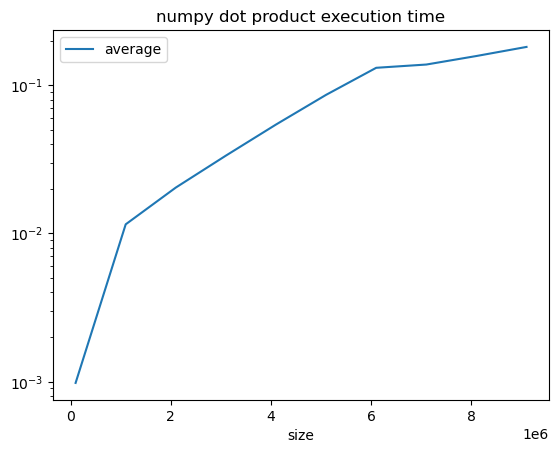

In [28]:
import matplotlib.pyplot as plt
huge_dot.plot(x='size', y="average", logy=True)
plt.title("numpy dot product execution time");

### Numpy einsum (Einstein summation convention)

In [29]:
def simple_dot_einsum(values):
    return numpy.einsum('i,i->', values, values)

values = list(range(10000000))
values = numpy.array(values, dtype=numpy.float32)
vect = values / numpy.max(values)
simple_dot_einsum(vect)

3333333.8

In [30]:
measure_time("simple_dot_einsum(values)",
             context=dict(simple_dot_einsum=simple_dot_einsum, values=vect))

{'average': 0.31504626851528883,
 'deviation': 0.010139563399098845,
 'min_exec': 0.3053227625787258,
 'max_exec': 0.3419850990176201,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

In [33]:
res = []
for i in range(100000, 10000000, 1000000):
    t = measure_time("simple_dot_einsum(values)", repeat=10,
                     context=dict(simple_dot_einsum=simple_dot_einsum, values=vect[:i].copy()))
    res.append(t)

einsum_dot = pandas.DataFrame(res)
einsum_dot.tail()

,average,deviation,min_exec,max_exec,repeat,number,size
5,0.135707,0.004191,0.128055,0.142518,10,50,5100000
6,0.172813,0.003569,0.168577,0.181538,10,50,6100000
7,0.207667,0.012584,0.195111,0.235194,10,50,7100000
8,0.236165,0.017691,0.222366,0.284044,10,50,8100000
9,0.274315,0.009711,0.264738,0.291817,10,50,9100000


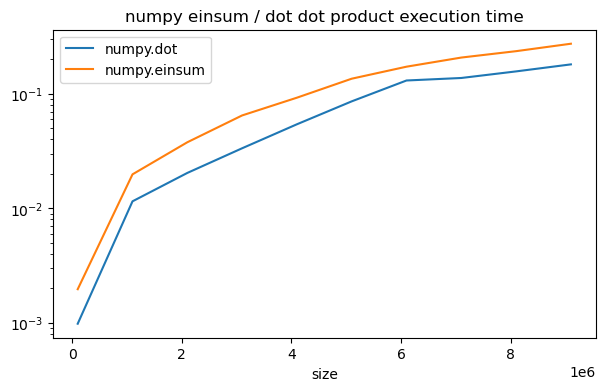

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(7,4))
huge_dot.plot(x='size', y="average", ax=ax, label="numpy.dot", logy=True)
einsum_dot.plot(x='size', y="average", ax=ax, logy=True,label="numpy.einsum")
ax.set_title("numpy einsum / dot dot product execution time");

### With C

In [35]:
from cpyquickhelper.numbers.cbenchmark_dot import empty_vector_dot_product
empty_vector_dot_product(vect, vect)

0.0

In [37]:
def empty_c11_dot(vect):
    return empty_vector_dot_product(vect, vect)

measure_time("empty_c11_dot(values)", 
             context=dict(empty_c11_dot=empty_c11_dot, values=vect), repeat=10)

{'average': 8.860668167471885e-05,
 'deviation': 2.272584158708471e-05,
 'min_exec': 7.522571831941605e-05,
 'max_exec': 0.00014635547995567322,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

In [38]:
from cpyquickhelper.numbers.cbenchmark_dot import vector_dot_product
vector_dot_product(vect, vect)

3334629.0

In [39]:
def c11_dot(vect):
    return vector_dot_product(vect, vect)

measure_time("c11_dot(values)", 
             context=dict(c11_dot=c11_dot, values=vect), repeat=10)

{'average': 0.6894298494793475,
 'deviation': 0.0020456696934384195,
 'min_exec': 0.6855588061735034,
 'max_exec': 0.6926732212305069,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

In [40]:
res = []
for i in range(100000, 10000000, 1000000):
    t = measure_time("c11_dot(values)", repeat=10,
                     context=dict(c11_dot=c11_dot, values=vect[:i].copy()))
    res.append(t)

cus_dot = pandas.DataFrame(res)
cus_dot.tail()

,average,deviation,min_exec,max_exec,repeat,number,size
5,0.350133,0.003687,0.343833,0.356814,10,50,5100000
6,0.428151,0.015370,0.419334,0.473698,10,50,6100000
7,0.490319,0.009413,0.478324,0.515792,10,50,7100000
8,0.569867,0.017506,0.558650,0.621213,10,50,8100000
9,0.640585,0.028537,0.618789,0.708937,10,50,9100000


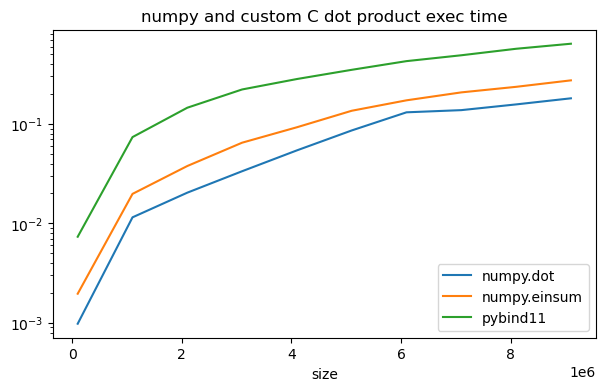

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(7,4))
huge_dot.plot(x='size', y="average", ax=ax, label="numpy.dot", logy=True)
einsum_dot.plot(x='size', y="average", ax=ax, logy=True,label="numpy.einsum")
cus_dot.plot(x='size', y="average", ax=ax, logy=True,label="pybind11")
ax.set_title("numpy and custom C dot product exec time");

### With BLAS
Internally, numpy is using BLAS. A direct call to it should give the same results.

In [43]:
from cpyquickhelper.numbers.direct_blas_lapack import cblas_sdot

def blas_dot(vect):
    return cblas_sdot(vect, vect)

measure_time("blas_dot(values)", context=dict(blas_dot=blas_dot, values=vect), repeat=10)

{'average': 0.20188149074092507,
 'deviation': 0.007104849597725998,
 'min_exec': 0.19536746758967638,
 'max_exec': 0.216043621301651,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

In [44]:
res = []
for i in range(100000, 10000000, 1000000):
    t = measure_time("blas_dot(values)", repeat=10,
                     context=dict(blas_dot=blas_dot, values=vect[:i].copy()))
    res.append(t)

blas_dot = pandas.DataFrame(res)
blas_dot.tail()

,average,deviation,min_exec,max_exec,repeat,number,size
5,0.089937,0.010135,0.068635,0.107185,10,50,5100000
6,0.122508,0.005985,0.108114,0.127884,10,50,6100000
7,0.142424,0.004154,0.133813,0.148821,10,50,7100000
8,0.179057,0.018446,0.160725,0.209565,10,50,8100000
9,0.204475,0.021608,0.181683,0.243043,10,50,9100000


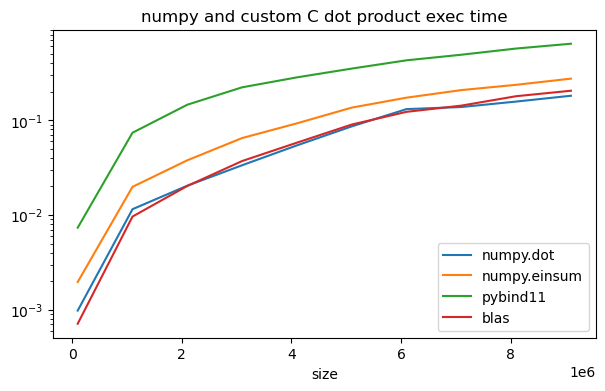

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(7,4))
huge_dot.plot(x='size', y="average", ax=ax, label="numpy.dot", logy=True)
einsum_dot.plot(x='size', y="average", ax=ax, logy=True,label="numpy.einsum")
cus_dot.plot(x='size', y="average", ax=ax, logy=True,label="pybind11")
blas_dot.plot(x='size', y="average", ax=ax, logy=True,label="blas")
ax.set_title("numpy and custom C dot product exec time");

### Use of branching: 16 multplications in one row
The code looks like what follows. If there is more than 16 multiplications left, we use function vector_dot_product_pointer16, otherwise, there are done one by one like the previous function.

In [46]:
from cpyquickhelper.numbers.cbenchmark_dot import vector_dot_product16_sse
vector_dot_product16_sse(vect, vect)

3333332.0

In [48]:
def c11_dot16_sse(vect):
    return vector_dot_product16_sse(vect, vect)

measure_time("c11_dot16_sse(values)", 
             context=dict(c11_dot16_sse=c11_dot16_sse, values=vect), repeat=10)

{'average': 0.3306755581870675,
 'deviation': 0.026013382580607144,
 'min_exec': 0.30384951177984476,
 'max_exec': 0.3741959547623992,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

In [49]:
res = []
for i in range(100000, 10000000, 1000000):
    t = measure_time("c11_dot16_sse(values)", repeat=10,
                     context=dict(c11_dot16_sse=c11_dot16_sse, values=vect[:i].copy()))
    res.append(t)

cus_dot16_sse = pandas.DataFrame(res)
cus_dot16_sse.tail()

,average,deviation,min_exec,max_exec,repeat,number,size
5,0.121315,0.010657,0.110461,0.141647,10,50,5100000
6,0.157343,0.010485,0.140225,0.175391,10,50,6100000
7,0.198457,0.006178,0.186487,0.209446,10,50,7100000
8,0.234433,0.013210,0.220229,0.258149,10,50,8100000
9,0.266719,0.005657,0.260637,0.278377,10,50,9100000


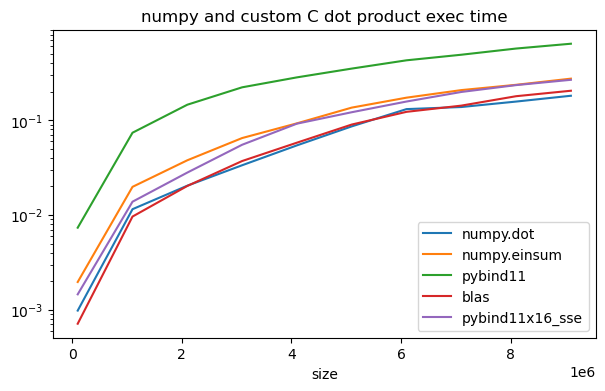

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(7,4))
huge_dot.plot(x='size', y="average", ax=ax, label="numpy.dot", logy=True)
einsum_dot.plot(x='size', y="average", ax=ax, logy=True,label="numpy.einsum")
cus_dot.plot(x='size', y="average", ax=ax, logy=True,label="pybind11")
blas_dot.plot(x='size', y="average", ax=ax, logy=True,label="blas")
cus_dot16_sse.plot(x='size', y="average", ax=ax, logy=True,label="pybind11x16_sse")
ax.set_title("numpy and custom C dot product exec time");

### OpenMP

In [51]:
from cpyquickhelper.numbers.cbenchmark_dot import vector_dot_product_openmp
vector_dot_product_openmp(vect, vect, 4)

3343080.75

In [54]:
def c11_dot_openmp4(vect):
    return vector_dot_product_openmp(vect, vect, nthreads=4)

measure_time("c11_dot_openmp4(values)",
             context=dict(c11_dot_openmp4=c11_dot_openmp4, values=vect), repeat=10)

{'average': 0.1723166199401021,
 'deviation': 0.005895961424369845,
 'min_exec': 0.16757927369326353,
 'max_exec': 0.18914479203522205,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

In [58]:
res = []
for i in range(100000, 10000000, 1000000):
    t = measure_time("c11_dot_openmp4(values)", repeat=10,
                     context=dict(c11_dot_openmp4=c11_dot_openmp4, values=vect[:i].copy()))
    res.append(t)

cus_dot_openmp4 = pandas.DataFrame(res)
cus_dot_openmp4.tail()

,average,deviation,min_exec,max_exec,repeat,number,size
5,0.087702,0.000942,0.086186,0.089058,10,50,5100000
6,0.105117,0.001111,0.103321,0.107411,10,50,6100000
7,0.122284,0.000740,0.120693,0.123034,10,50,7100000
8,0.147781,0.009781,0.137429,0.162729,10,50,8100000
9,0.162752,0.010089,0.156815,0.192047,10,50,9100000


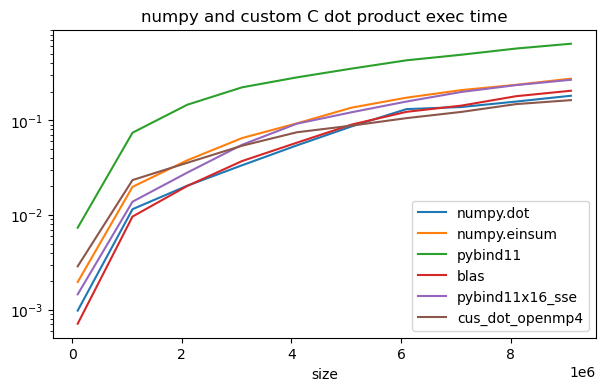

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(7,4))
huge_dot.plot(x='size', y="average", ax=ax, label="numpy.dot", logy=True)
einsum_dot.plot(x='size', y="average", ax=ax, logy=True,label="numpy.einsum")
cus_dot.plot(x='size', y="average", ax=ax, logy=True,label="pybind11")
blas_dot.plot(x='size', y="average", ax=ax, logy=True,label="blas")
cus_dot16_sse.plot(x='size', y="average", ax=ax, logy=True,label="pybind11x16_sse")
cus_dot_openmp4.plot(x='size', y="average", ax=ax, label="cus_dot_openmp4")
ax.set_title("numpy and custom C dot product exec time");